## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')


## Read Data and convert in datetime format

In [2]:
data1=pd.read_csv(r'C:\Users\ahtis\OneDrive\Desktop\New folder\00221634.csv')
data=pd.read_csv(r'C:\Users\ahtis\OneDrive\Desktop\New folder\00221634.csv')
data.shape

(45379, 2)

In [3]:
data['Timestamp']=pd.to_datetime(data['Timestamp'], infer_datetime_format=True)
data=data.set_index(['Timestamp'])
data.head()

,glucose
Timestamp,
2018-08-04 23:53:51,153.0
2018-08-04 23:48:51,155.0
2018-08-04 23:43:51,159.0
2018-08-04 23:38:51,164.0
2018-08-04 23:33:51,172.0


## Plot Raw data

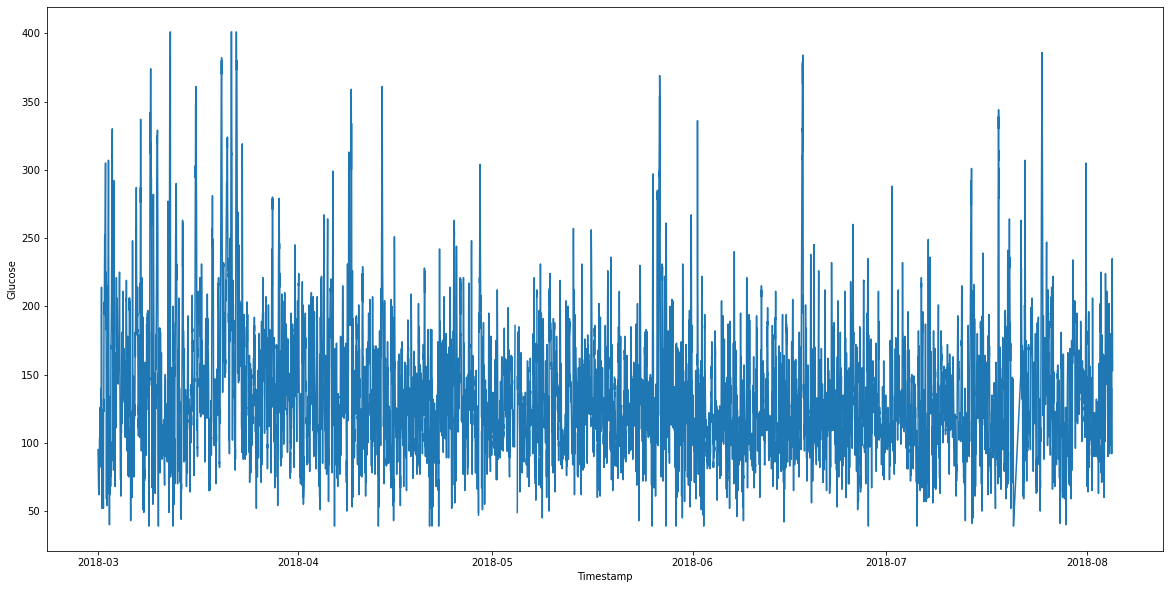

In [4]:

plt.figure(figsize=(20,10))
plt.xlabel("Timestamp")
plt.ylabel("Glucose")
plt.plot(data)

## Rolling Mean and Standard Deviation
The rolling mean and standard devistion should be constant (not changing over time in upward or downward trend). In this case it is not moving with any trend over time. It is rather constant with fluctuations in a speciic range. 

### Window size = 288 for mean and standard deviation ( 1 day for our data) 

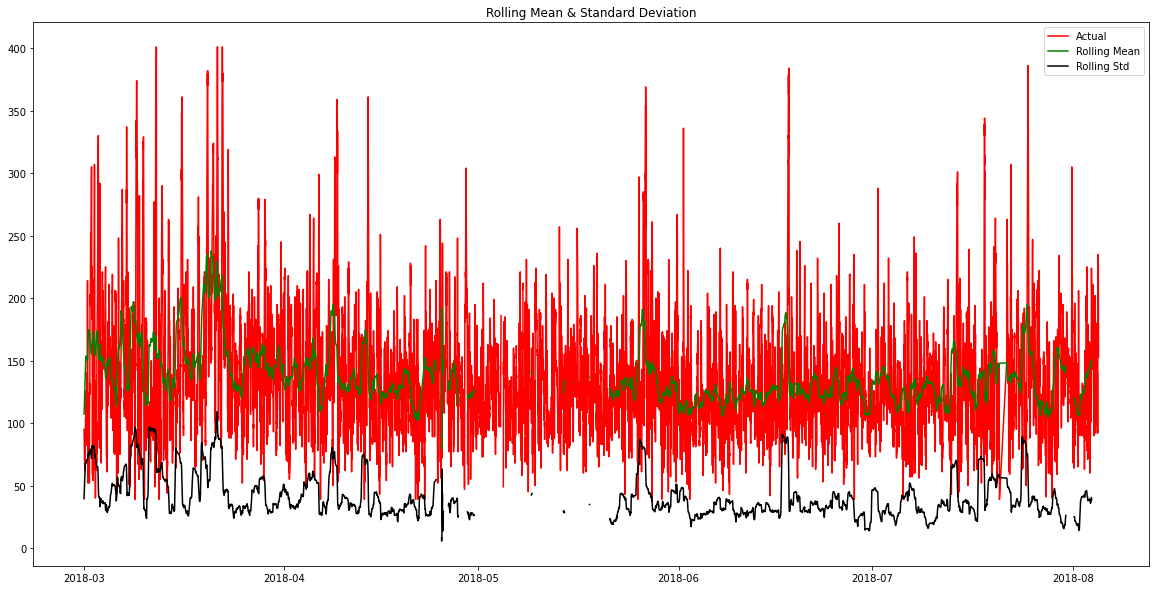

In [5]:
## Using 1 day window
rolmean=data.rolling(window=288).mean()
rolstd=data.rolling(window=288).std()
plt.figure(figsize=(20,10))
actual=plt.plot(data, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Window size = 60 for mean and standard deviation ( 5 hours for our data) 

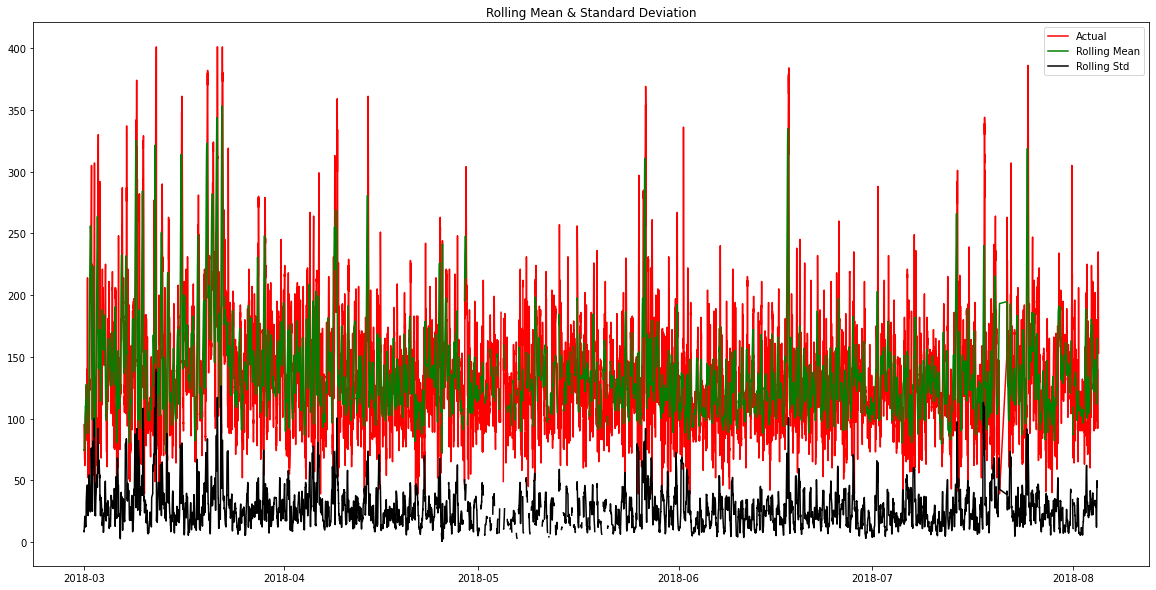

In [6]:
## Using 5 hours window
rolmean=data.rolling(window=60).mean()
rolstd=data.rolling(window=60).std()
plt.figure(figsize=(20,10))
actual=plt.plot(data, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## AD Fuller test to check and confirm stationarity / non-stationarity.
The 5% value is greater than ADF statistic. Also p-value is less than 0.05. Hence Time series is stationary in our case. 

In [7]:
data = data.dropna()
X = data["glucose"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -22.313658
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


## Decompostion
Decomposition helps to check if there is any treand and seasonal componet available in our data. there are two types of Decompositions. 

Multiplicative Decomposition refers to a decomposition in which all the components like seasonal componet , treand component afte multiplication with each other form the original raw data.

Aditive Decomposition refers to a decomposition in which all the components like seasonal componet , treand component after addition with each other form the original raw data.

The results show no seasonality on the data.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Multiplicative Decomposition 
mul_result = seasonal_decompose(data['glucose'], model='multiplicative',period=1)

# Additive Decomposition
add_result = seasonal_decompose(data['glucose'], model='additive',period=1)

Text(0.5, 0.98, '\nMultiplicative Decompose')

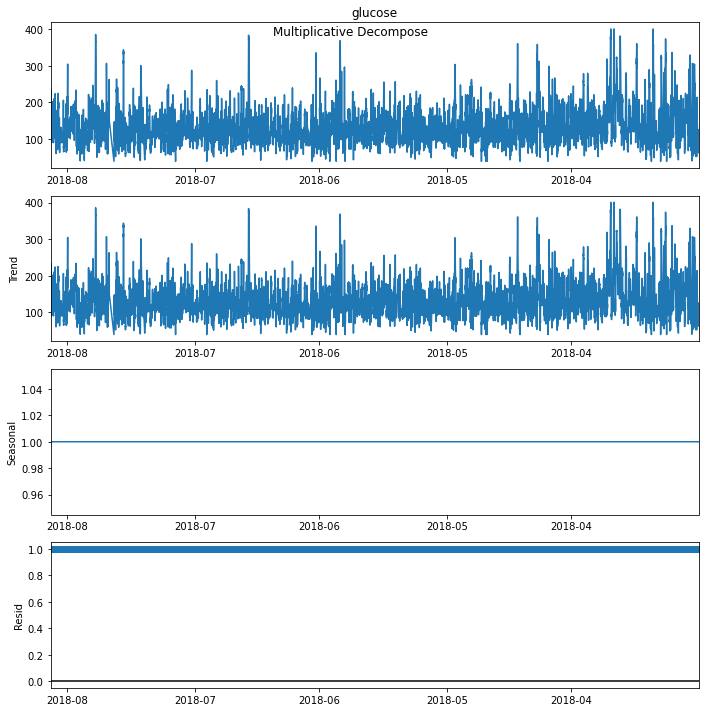

In [9]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

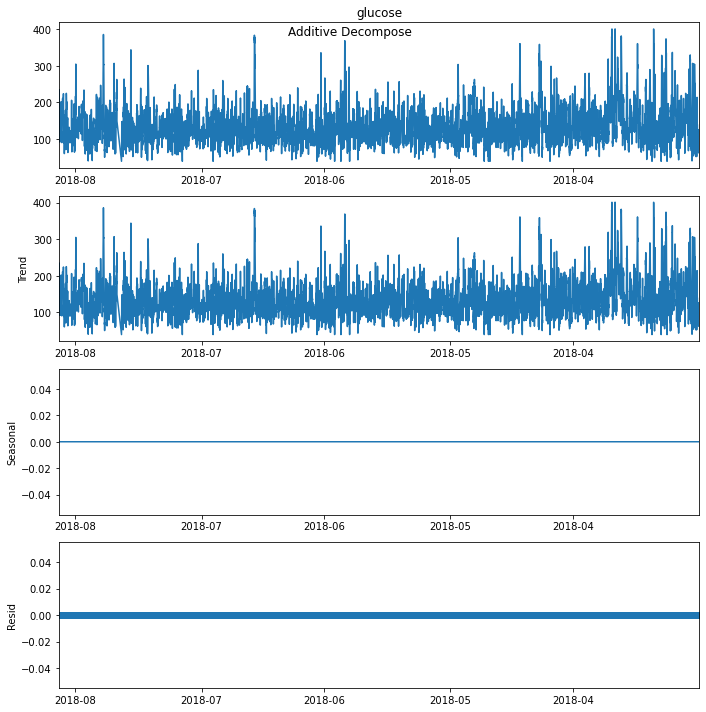

In [10]:
add_result.plot().suptitle('\nAdditive Decompose', fontsize=12)
plt.show()

## ACF and PACF
ACF and PACF are used to obtain relation between current observation and previsous observations. The graphs also demonstrate how many previous values of lags should be considered while calculating the future predictions. 

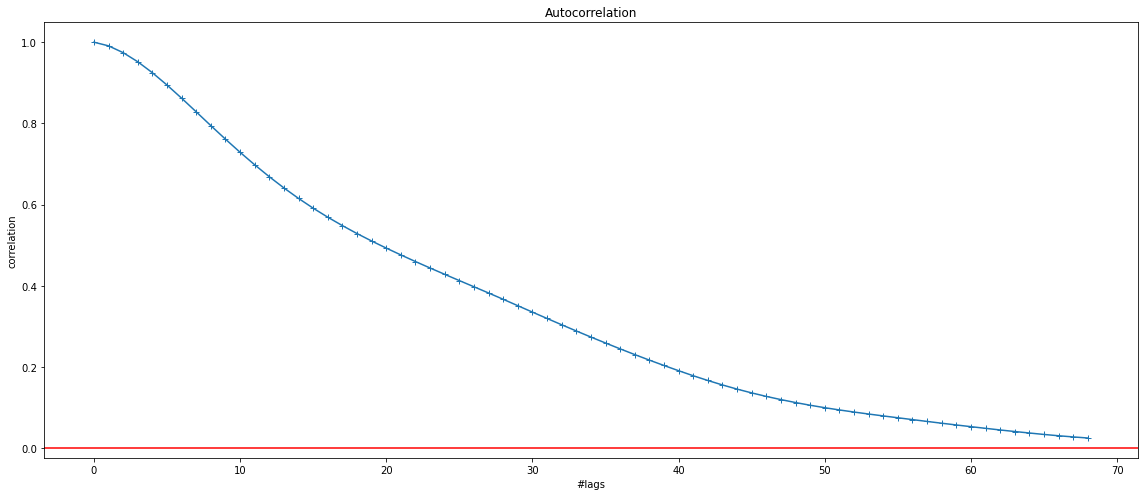

In [11]:
from statsmodels.tsa.stattools import acf, pacf
data = data.dropna()
ACF_lag= acf(data, nlags=68)


plt.figure(figsize=(16, 7))
plt.plot(ACF_lag,marker='+')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.title('Autocorrelation')
plt.xlabel('#lags')
plt.ylabel('correlation')
plt.tight_layout()



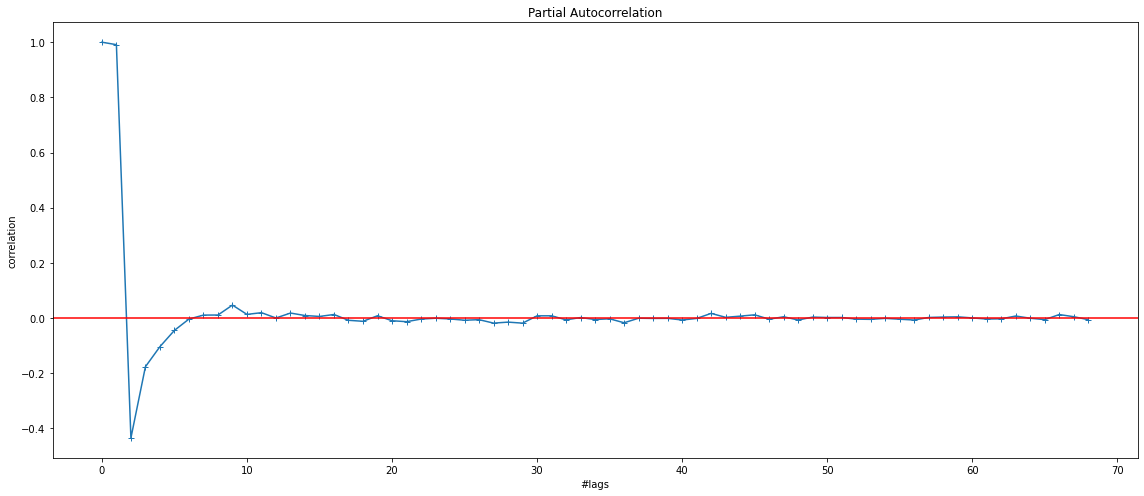

In [12]:
data = data.dropna()
PACF_lag = pacf(data, nlags=68, method='ols')

plt.figure(figsize=(16, 7))
plt.plot(PACF_lag,marker='+')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.title('Partial Autocorrelation')
plt.xlabel('#lags')
plt.ylabel('correlation')
plt.tight_layout()

## AR Model
AR model is autoregressive model. Here it has been individually demonstrated. 
Results showgood predicted value with lag value of 2000. Lower the number of lag values used, poor the result is. 

In [13]:
from statsmodels.tsa.ar_model import AutoReg

45263     96.323069
45264     96.740173
45265     98.288630
45266     99.256242
45267    102.130703
            ...    
46259    161.273360
46260    161.480817
46261    160.750812
46262    159.212323
46263    158.362064
Length: 1001, dtype: float64


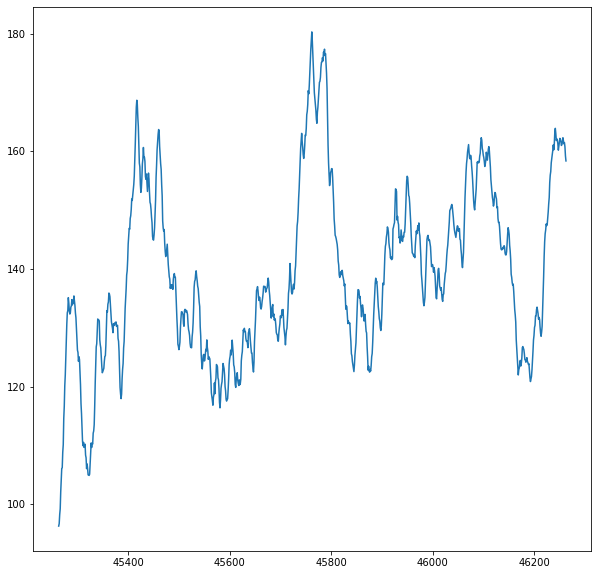

In [14]:
ARmodel = AutoReg(data, lags=2000) 
ARmodel_fit = ARmodel.fit() 
ypredicted = ARmodel_fit.predict(len(data),len(data)+1000)
print(ypredicted)
plt.plot(ypredicted)

## Auto Arima Model
This model is completely automotive and it first checks the stationarity itself. Without data being stationary the time series model cannot work on it. It iterates over different values of p,d,q and selects the one with the best results i.e. lowest aic value. 

In this work it is preforming poorly. According to my understanding, the p value which is for AR model should be high. It is 2 in this case. The lags used in independent AR model were 2000. Here it it is auto selecting all the parameters. 

In [15]:
from pmdarima import auto_arima
data1 = data1.dropna()

model = auto_arima(data1["glucose"],trace=True,error_action="ignore",suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=285128.832, Time=55.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=296549.248, Time=1.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=287365.726, Time=1.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=290037.000, Time=4.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=296547.250, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=285838.243, Time=11.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=285838.903, Time=11.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=285279.781, Time=70.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=76.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=285839.494, Time=6.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=285759.337, Time=19.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=285791.094, Time=18.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=82.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=20.21 sec

Best model:  ARI

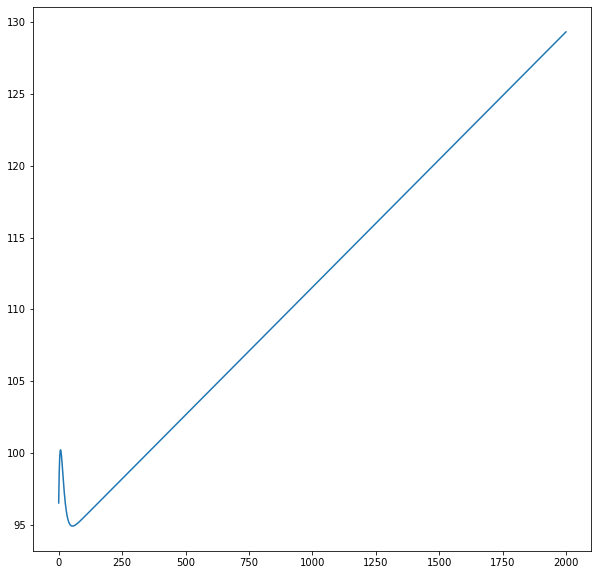

In [16]:
forecast = model.predict(n_periods=2000)
plt.plot(forecast)

## Arima Model
This model can be manually tuned for p,q,d values.

In this work it is preforming poorly. According to my understanding, the p value which is for AR model should be high. It is 2 in this case. The lags used in independent AR model were 2000(which performed quite better). 
The issue with selecting high p value is the computational limitation. It takes alot of time if we incrase the value of parameters. Also the datapoints that have been use are just around 5000, due to computational issues. 

There are two models predictions given below, one with p value of 2 and one with p value of 5. 

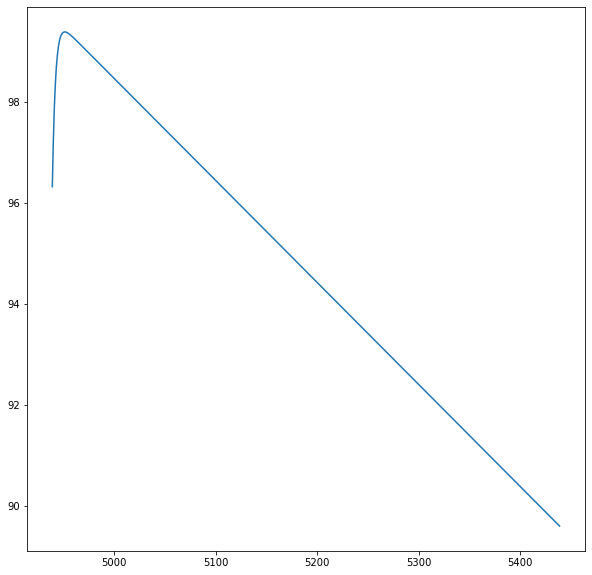

In [43]:
from statsmodels.tsa.arima_model import ARIMA
data = data1[40323:45323]
ARIMAmodel = ARIMA(data['glucose'], order=(2, 1, 2))
ARIMA_model_fit = ARIMAmodel.fit(disp=False)

# make prediction
ypredicted = ARIMA_model_fit.predict(len(data), len(data)+500, typ='levels')
plt.plot(ypredicted)

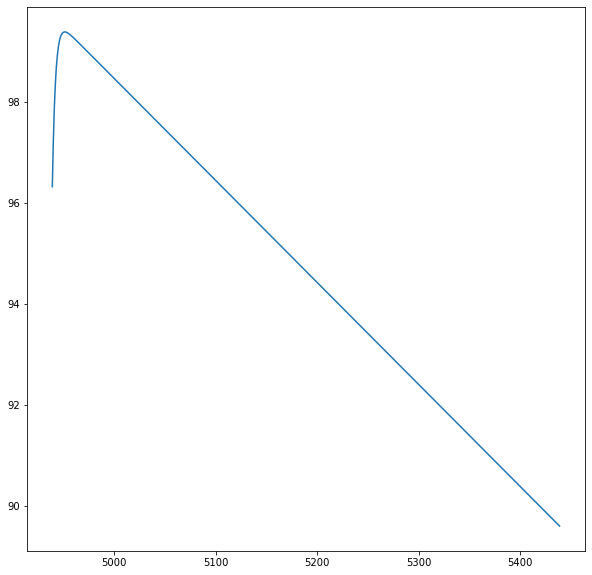

In [44]:
data = data1[40323:45323]
ARIMAmodel = ARIMA(data['glucose'], order=(2, 1, 2))
ARIMA_model_fit = ARIMAmodel.fit(disp=False)

# make prediction
ypredicted = ARIMA_model_fit.predict(len(data), len(data)+500, typ='levels')
plt.plot(ypredicted)